# PSF Check Energy

This notebook checks the self-conistency of the application of the PSF in Gammapy for event sampling and binned fitting. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from gammapy.maps import WcsGeom, MapAxis, MapCoord, Map, ImageProfileEstimator
from gammapy.data import GTI, Observation, DataStore
from gammapy.irf import EnergyDependentMultiGaussPSF, load_cta_irfs
from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker
from gammapy.utils.random import sample_powerlaw
from gammapy.utils.random import InverseCDFSampler, get_random_state


In [3]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
IRF_FILE_HESS = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
POINTING = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")

ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=9)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=9, name="energy_true")

RAD_AXIS = MapAxis.from_bounds(0, 0.5, nbin=60, unit="deg", interp="lin")

N_EVENTS = 200_000

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=2, binsz=0.002, frame="galactic", axes=[ENERGY_AXIS]
)

WCS_GEOM_TRUE = WcsGeom.create(
    skydir=POINTING, width=2, binsz=0.002, frame="galactic", axes=[ENERGY_AXIS_TRUE]
)


POSITION_TRUE = SkyCoord(0, 0, frame="galactic", unit="deg")

In [4]:
def make_psf_map(psf):
    pointing = SkyCoord(1, 0, frame="galactic", unit="deg")
    irfs = load_cta_irfs(IRF_FILE)
    irfs["psf"] = psf
    obs = Observation.create(pointing=pointing, livetime="1 h", irfs=irfs)
    
    geom = WcsGeom.create(
        skydir=pointing, width=(1, 1), binsz=0.01, frame="galactic", axes=[ENERGY_AXIS]
    )
    dataset_empty = MapDataset.create(geom=geom, energy_axis_true=ENERGY_AXIS_TRUE)
    
    maker = MapDatasetMaker(selection=["psf"])
    
    dataset = maker.run(dataset_empty, obs)
    return dataset.psf

In [17]:
def sample_events_psf(psf_map):
    emin, emax = ENERGY_AXIS_TRUE.edges[0], ENERGY_AXIS_TRUE.edges[-1]
    energy = sample_powerlaw(emin.value, emax.value, size=N_EVENTS, gamma=1) * ENERGY_AXIS.unit
    coords = MapCoord.create({"skycoord": POSITION_TRUE, "energy_true": energy})
    coords_reco = psf_map.sample_coord(coords)
    return coords_reco

In [13]:
def plot_psf_profiles(psf_kernel_map, energy):
    estimator = ImageProfileEstimator(
        method="sum", axis="radial", center=POSITION_TRUE, x_edges=Angle(RAD_AXIS.edges)
    )
    
    psf_image = psf_kernel_map.get_image_by_coord({"energy_true": energy})
    profile = estimator.run(psf_image)
    values = profile.table["profile"]

    norm = 1 / (RAD_AXIS.bin_width * values).sum()
    
    ax = plt.plot(RAD_AXIS.center.value, norm * values, label="PSF Kernel")
        
    plt.xlim(0.01, 0.5)
    plt.legend()
        
    
def plot_event_profiles(events, energy_min, energy_max):
    selection = (events["energy_true"] < energy_max) & (events["energy_true"] > energy_min)
    separaration = POSITION_TRUE.separation(events.skycoord)[selection]
    data, _ = np.histogram(separaration.value, bins=RAD_AXIS.edges.value)
    #data = data * RAD_AXIS.center.value
    norm = 1 / (RAD_AXIS.bin_width.value * data).sum()
    
    plt.step(RAD_AXIS.center.value, data * norm, label="Sampled PSF", where="mid")
    
    
def plot_psf_comparison(events_iact, psf_kernel):
    plt.figure(figsize=(12, 12))
    idx = 1
    for e_min, e_max in zip(ENERGY_AXIS.edges[:-1], ENERGY_AXIS.edges[1:]):
        ax = plt.subplot(3, 3, idx)
        plot_event_profiles(events_iact, energy_min=e_min, energy_max=e_max)
        energy = np.sqrt(e_min * e_max)
        plot_psf_profiles(psf_kernel.psf_kernel_map, energy=energy)
        idx +=1
        ax.set_title(f"{energy:.2f}")

## CTA PSF

In [7]:
psf_cta = EnergyDependentMultiGaussPSF.read(filename=IRF_FILE, hdu="POINT SPREAD FUNCTION")

In [8]:
psf_map_cta = make_psf_map(psf_cta)

In [9]:
psf_kernel = psf_map_cta.get_psf_kernel(position=POSITION_TRUE, geom=WCS_GEOM_TRUE)

In [10]:
psf_kernel.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [18]:
events_cta = sample_events_psf(psf_map_cta)

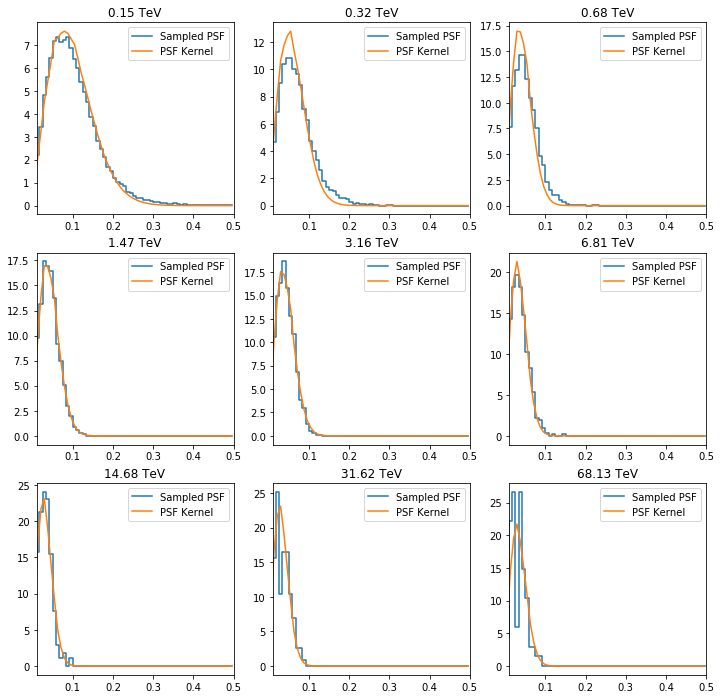

In [19]:
plot_psf_comparison(events_cta, psf_kernel)

In [20]:
counts = Map.from_geom(geom=psf_kernel.psf_kernel_map.geom)
counts.fill_by_coord(events_cta)

In [21]:
counts.smooth("0.005 deg").plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

## HESS PSF 

In [22]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
observations = datastore.get_observations([23592])

In [23]:
psf_hess = observations[0].psf

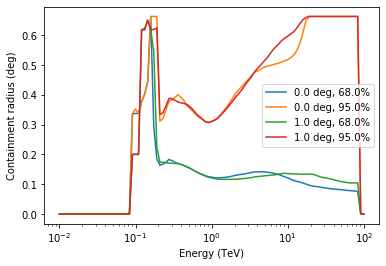

In [24]:
psf_hess.plot_containment_vs_energy()

In [25]:
psf_map_hess = make_psf_map(psf_hess)

In [27]:
psf_kernel_hess = psf_map_hess.get_psf_kernel(position=POSITION_TRUE, geom=WCS_GEOM_TRUE)

In [28]:
psf_kernel_hess.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [29]:
events_hess = sample_events_psf(psf_map_hess)

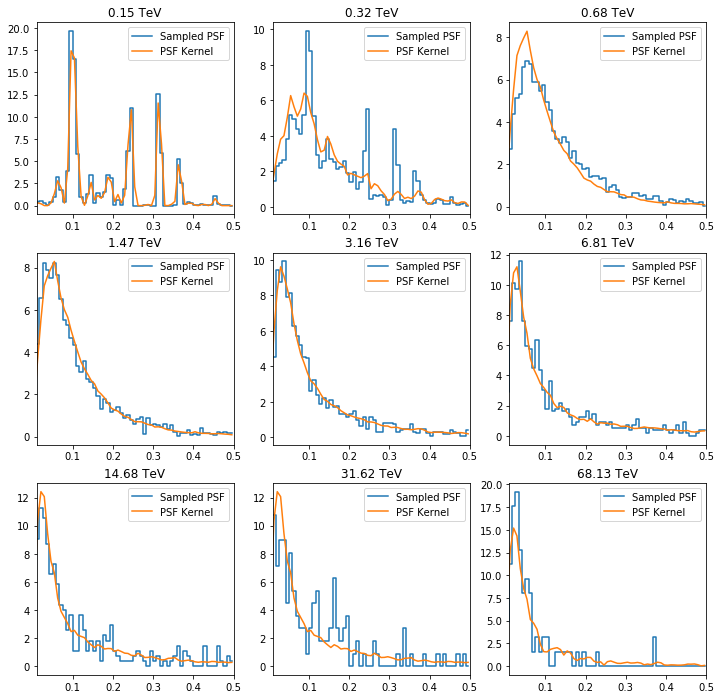

In [30]:
plot_psf_comparison(events_hess, psf_kernel_hess)

In [31]:
counts = Map.from_geom(geom=psf_kernel_hess.psf_kernel_map.geom)
counts.fill_by_coord(events_hess)
counts.smooth("0.005 deg").plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

## Gaussian PSF

In [32]:
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=IRF_FILE, hdu="POINT SPREAD FUNCTION")
psf_gauss.sigmas[0][:] =  0.1
psf_gauss.norms[0][:] = 1
psf_3d = psf_gauss.to_psf3d(rad=RAD_AXIS.edges)

In [33]:
# psf_3d.plot_containment_vs_energy()

In [35]:
psf_map_gauss = make_psf_map(psf_3d)
psf_kernel_gauss = psf_map_gauss.get_psf_kernel(position=POSITION_TRUE, geom=WCS_GEOM_TRUE)
psf_kernel_gauss.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

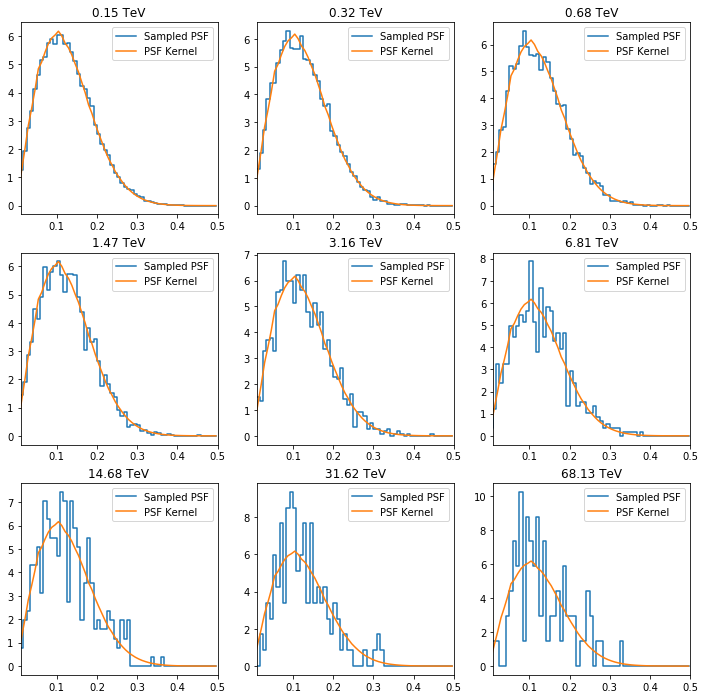

In [36]:
events_gauss = sample_events_psf(psf_map_gauss)
plot_psf_comparison(events_gauss, psf_kernel_gauss)

In [37]:
counts = Map.from_geom(geom=psf_kernel_gauss.psf_kernel_map.geom)
counts.fill_by_coord(events_gauss)
counts.smooth("0.005 deg").plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

### Conclusion

- I checked carefully and the profile from the events as well as the image profile are computed the same way (just summing up all contributions in rad bins). Still from comparing the profiles one can see, that they are inconsistent. The only logical conclusion is that we forgot to take into account the Jacobian when computig the PDF for the PSF sampling (https://github.com/gammapy/gammapy/blob/master/gammapy/cube/psf_map.py#L382).

### TODO:
- Add a check for the HESS PSF and a simple Gaussian PSF to this notebook (DONE)
- Fix the bug by taking into acocount the Jacobian (r * dr) in `PSFMap.sample_coord()` (linked above) (DONE)
- Re-run this notebook to verify the fix (DONE)
- Submit PR and re-run the event sampling checks in `gammapy-bechmarks` (DONE)